In [51]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import *

In [52]:
df = pd.read_csv("./DATA/Epilepsy/data.csv")

In [53]:
num_columns = len(df.columns)
print(len(df.index), num_columns)

11500 180


In [54]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def Oversample(data, labels):
    zeros = []
    ones = []
    for (index, label) in enumerate(labels):
        if label == 0:
            zeros.append(data[index])
        else:
            ones.append(data[index])

    zeros, ones = np.array(zeros), np.array(ones)
    ids = np.arange(len(ones))
    choices = np.random.choice(ids, len(zeros)) #choose entries from so that number of ones and zeroes are the same 

    res_ones_features = ones[choices]
    res_ones_labels = np.ones(len(res_ones_features))

    resampled_features = np.concatenate([res_ones_features, zeros], axis=0)
    resampled_labels = np.concatenate([res_ones_labels, np.zeros(len(zeros))], axis=0)

    return unison_shuffled_copies(resampled_features, resampled_labels)
        

In [55]:
df.head() #each row represents one second

,xx,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [56]:
df = df.sample(frac=1) #shuffle dataset
data = df.drop(['y', 'xx'], axis=1).to_numpy()
labels = df['y'].to_numpy()

count= 0
#map labels to binary - class 1 has epilepsy only. so class 1 for yes epilepsy, 0 for no
for (i,l) in enumerate(labels):
    if l != 1:
        labels[i] = 0
        count+=1
all_labels = list(set(df['y'].unique().tolist()))
print(all_labels)
print(count)

[0, 1]
9200


Class Weighting

In [57]:
total = len(df.index)
num_zeroes = count
num_ones = total - num_zeroes
print(num_zeroes, num_ones)
zero_weight = (1/num_zeroes)*total/2
one_weight = (1/num_ones)*total/2
class_weight = {0: zero_weight, 1: one_weight}
print(class_weight)

9200 2300
{0: 0.625, 1: 2.5}


In [58]:
data, labels = Oversample(data, labels)

In [59]:
norm = np.linalg.norm(data, axis=0)
data = data/norm

In [60]:
# len(norm)

In [61]:
assert(len(data) == len(labels))
train, validate, test = np.split(data, [int(.6*len(data)), int(.8*len(data))])
train_labels, validate_labels, test_labels = np.split(labels, [int(.6*len(labels)), int(.8*len(labels))])

In [62]:
print(train.shape, validate.shape, test.shape)

train = np.expand_dims(train, axis=2)
validate = np.expand_dims(validate, axis=2)
test = np.expand_dims(test, axis=2)
print(train.shape, validate.shape, test.shape)

(11040, 178) (3680, 178) (3680, 178)
(11040, 178, 1) (3680, 178, 1) (3680, 178, 1)


In [63]:
# train_labels = train_labels.reshape((-1,1))
# validate_labels = validate_labels.reshape((-1,1))
# test_labels = test_labels.reshape((-1,1))

Build and Train The Model

In [64]:
EPOCHS = 10
BATCH_SIZE = 32
INPUT_SHAPE = (num_columns-2, 1)
DROPOUT = 0.1
FILTERS = 16
UNITS = 16
POOL_SIZE = 2

In [65]:
def Model():
    input = layers.Input(shape=INPUT_SHAPE)
    conv1 = layers.Conv1D(FILTERS, kernel_size=2)(input)
    pool1 = layers.MaxPool1D(POOL_SIZE)(conv1)
    conv2 = layers.Conv1D(FILTERS*2, kernel_size=2)(pool1)
    pool2 = layers.MaxPool1D(POOL_SIZE)(conv2)
    conv3 = layers.Conv1D(FILTERS*3, kernel_size=2)(pool2)
    pool3 = layers.MaxPool1D(POOL_SIZE)(conv3)

    flatten = layers.Flatten()(pool3)
    fc1 = layers.Dense(UNITS, activation = 'relu')(flatten)
    d1 = layers.Dropout(DROPOUT)(fc1)
    fc2 = layers.Dense(UNITS, activation = 'relu')(d1)
    d2 = layers.Dropout(DROPOUT)(fc2)

    output = layers.Dense(1, activation='sigmoid')(d2)
    model = tf.keras.Model(inputs=input, outputs=output)
    return model
model = Model()
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 178, 1)]          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 177, 16)           48        
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 88, 16)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 87, 32)            1056      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 43, 32)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 42, 48)            3120      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 21, 48)           

In [66]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-7),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [67]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)

history = model.fit(train, train_labels, 
epochs=EPOCHS, 
validation_data=(validate, validate_labels), 
batch_size=BATCH_SIZE, 
verbose=2, 
callbacks=[callback],
# class_weight=class_weight,
shuffle=True)

Epoch 1/10
345/345 - 3s - loss: 0.0000e+00 - accuracy: 0.5668 - val_loss: 0.0000e+00 - val_accuracy: 0.6560
Epoch 2/10
345/345 - 3s - loss: 0.0000e+00 - accuracy: 0.7209 - val_loss: 0.0000e+00 - val_accuracy: 0.7948
Epoch 3/10
345/345 - 3s - loss: 0.0000e+00 - accuracy: 0.7966 - val_loss: 0.0000e+00 - val_accuracy: 0.8383
Epoch 4/10
345/345 - 3s - loss: 0.0000e+00 - accuracy: 0.8053 - val_loss: 0.0000e+00 - val_accuracy: 0.8174
Epoch 5/10
345/345 - 3s - loss: 0.0000e+00 - accuracy: 0.7860 - val_loss: 0.0000e+00 - val_accuracy: 0.7783
Epoch 6/10
345/345 - 3s - loss: 0.0000e+00 - accuracy: 0.7585 - val_loss: 0.0000e+00 - val_accuracy: 0.7533
Epoch 7/10
345/345 - 3s - loss: 0.0000e+00 - accuracy: 0.7375 - val_loss: 0.0000e+00 - val_accuracy: 0.7220
Epoch 8/10
345/345 - 3s - loss: 0.0000e+00 - accuracy: 0.7126 - val_loss: 0.0000e+00 - val_accuracy: 0.6951
Epoch 9/10
345/345 - 3s - loss: 0.0000e+00 - accuracy: 0.6850 - val_loss: 0.0000e+00 - val_accuracy: 0.6660


In [68]:
# model.save("./Models/Epilepsy_LSTM1.h5")

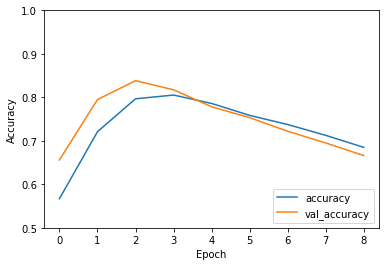

In [69]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [70]:
test_loss, test_acc = model.evaluate(test,  test_labels, verbose=2)

115/115 - 0s - loss: 0.0000e+00 - accuracy: 0.6660


In [71]:
test_labels[:50]

array([0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1.,
       0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1.])

In [72]:
# prediction = model.predict(np.expand_dims(test[0], axis=0))
prediction = model.predict(test)
print(prediction.shape)
for p in prediction[:50]:
    print(p)
    # print(np.argmax(prediction))

(3680, 1)
[0.499447]
[0.50052905]
[0.5012307]
[0.49946818]
[0.4996375]
[0.49999586]
[0.49966356]
[0.49976483]
[0.49937782]
[0.4995391]
[0.49982148]
[0.5030333]
[0.49946266]
[0.50002074]
[0.4999205]
[0.49944445]
[0.49964094]
[0.49948755]
[0.49950033]
[0.4994914]
[0.49928775]
[0.49968454]
[0.49943757]
[0.50019324]
[0.49938822]
[0.4996522]
[0.49926978]
[0.4996621]
[0.4995606]
[0.49954087]
[0.5009186]
[0.49947107]
[0.499421]
[0.5002623]
[0.49947646]
[0.4997603]
[0.49945012]
[0.49928722]
[0.49952826]
[0.49965784]
[0.49951425]
[0.49942544]
[0.49937353]
[0.49961486]
[0.5005113]
[0.49946916]
[0.49930257]
[0.49944636]
[0.49948856]
[0.49952933]
